# How does Chemical Potential Affect Linker Lengths and Cluster Size?

#### Specify Package Root Directory

In [1]:
import os
import sys

# Get the absolute path of the notebook's directory
notebook_directory = os.path.dirname(os.path.abspath('__file__'))

# Navigate one level up to get the root directory path
root_directory = os.path.abspath(os.path.join(notebook_directory, '..'))

# Change the working directory to the root directory
os.chdir(root_directory)

# Append the root directory to sys.path
sys.path.append(root_directory)

#### Import Modules

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sliding_nucleosome.nucleo_arr as nuc

#### Characterize Simulations

In [7]:
# Specify the directory containing all simulations
out_dir = "/scratch/users/jwakim/sliding_nucleosome/output/final_sims"
frac_methylated = 0.1

# List simulations
sims = os.listdir(out_dir)
sims = [sim for sim in sims if sim.startswith("sim_") and os.path.isdir(os.path.join(out_dir, sim))]
sim_inds = [int(sim.split("_")[1]) for sim in sims]
sims = [sim for _, sim in sorted(zip(sim_inds, sims))]
sim_inds = np.sort(sim_inds)

# Simulations vary in chain length
sim_paths = {}
latest_snap_paths = {}
sim_to_len = {}
len_to_sim = {}
all_len = set()
for i, sim in enumerate(sims):
    
    if (i+1) % 50 == 0:
        print(f"Sim {i+1} of {len(sims)}")

    # Identify the latest snapshot
    sim_path = os.path.join(out_dir, sim)
    sim_paths[sim] = sim_path
    snaps = os.listdir(sim_path)
    snaps = [snap for snap in snaps if snap.startswith("snap_") and snap.endswith(".json")]
    snaps = [snap for snap in snaps if snap != "snap_init.json"]
    snap_inds = [int(snap.split("_")[-1].split(".")[0]) for snap in snaps]
    last_snap = snaps[np.argmax(snap_inds)]
    snap_path = os.path.join(sim_path, last_snap)
    latest_snap_paths[sim] = snap_path
    
    # Load configuration
    nuc_arr = nuc.NucleosomeArray.load(snap_path)
    
    # Identify the chain length
    n_beads = nuc_arr.n_beads
    sim_to_len[sim] = n_beads
    
    # Store the chain length
    if n_beads not in all_len:
        len_to_sim[n_beads] = [sim]
        all_len.add(n_beads)
    else:
        len_to_sim[n_beads].append(sim)

Sim 50 of 505
Sim 100 of 505
Sim 150 of 505
Sim 200 of 505
Sim 250 of 505
Sim 300 of 505
Sim 350 of 505
Sim 400 of 505
Sim 450 of 505
Sim 500 of 505


#### Compute Average In-Range Parameter (Gamma)

In [8]:
all_chain_lengths = list(len_to_sim.keys())

In [9]:
all_mu = {chain_length: {} for chain_length in all_chain_lengths}
all_avg_gamma = {chain_length: {} for chain_length in all_chain_lengths}

for chain_length in all_chain_lengths:
    sims = len_to_sim[chain_length]
    for sim in sims:
        
        # Identify latest snapshot
        sim_path = sim_paths[sim]
        snap_path = latest_snap_paths[sim]
        
        # Load configuration
        nuc_arr = nuc.NucleosomeArray.load(snap_path)
        
        # Compute average gamma parameter
        all_avg_gamma[chain_length][sim] = np.average(nuc_arr.gamma)
        
        # Store the chemical potential
        all_mu[chain_length][sim] = nuc_arr.mu[0]

#### Plot Gamma vs. Chemical Potential for Fixed Chain Length

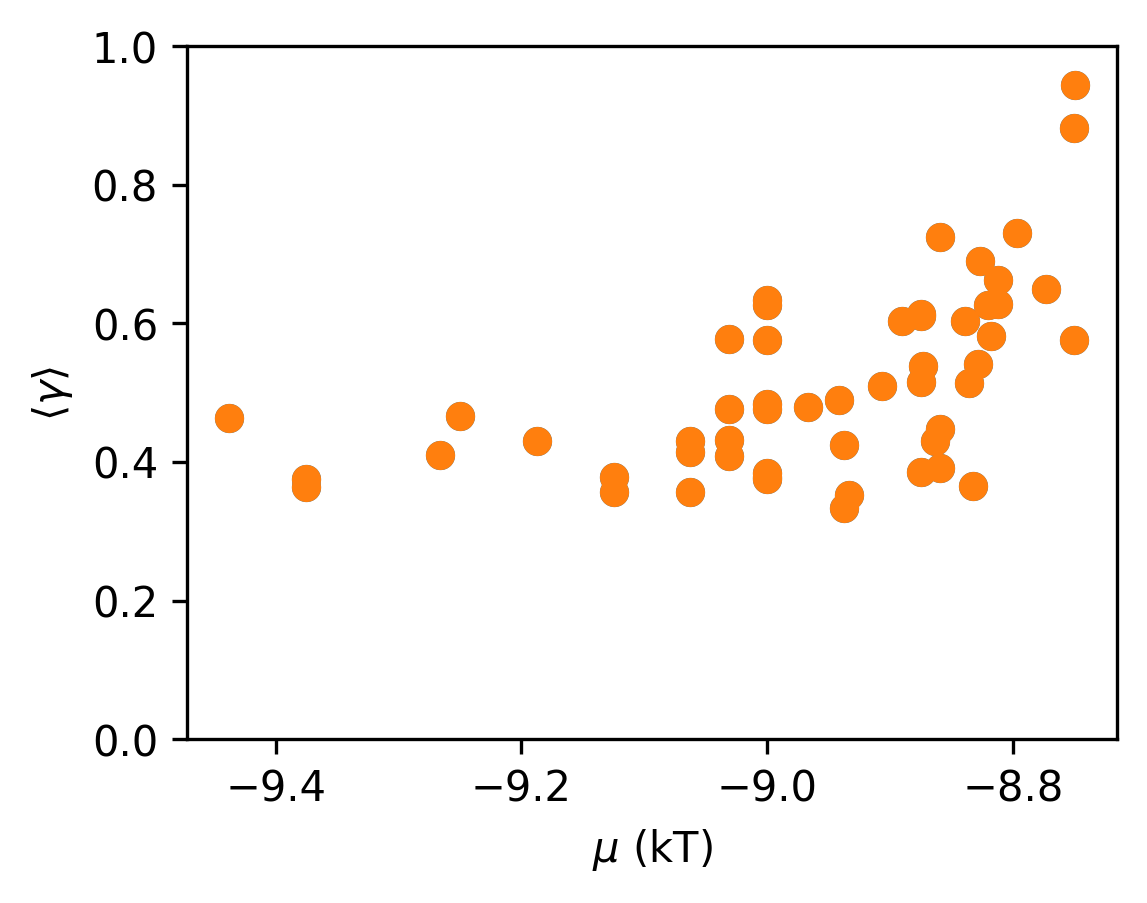

In [21]:
chain_length = 500
mu_plot = list(all_mu[chain_length].values())
avg_gamma_plot = list(all_avg_gamma[chain_length].values())

plt.figure(figsize=(4, 3), dpi=300)
plt.scatter(mu_plot, avg_gamma_plot) # So the color for N = 500 is consistent with the plot below
plt.scatter(mu_plot, avg_gamma_plot)
plt.xlabel(r"$\mu$ (kT)")
plt.ylabel(r"$\langle\gamma\rangle$")
plt.ylim((0, 1))
plt.show()

#### Plot Gamma vs. Chemical Potential for Variable Chain Length

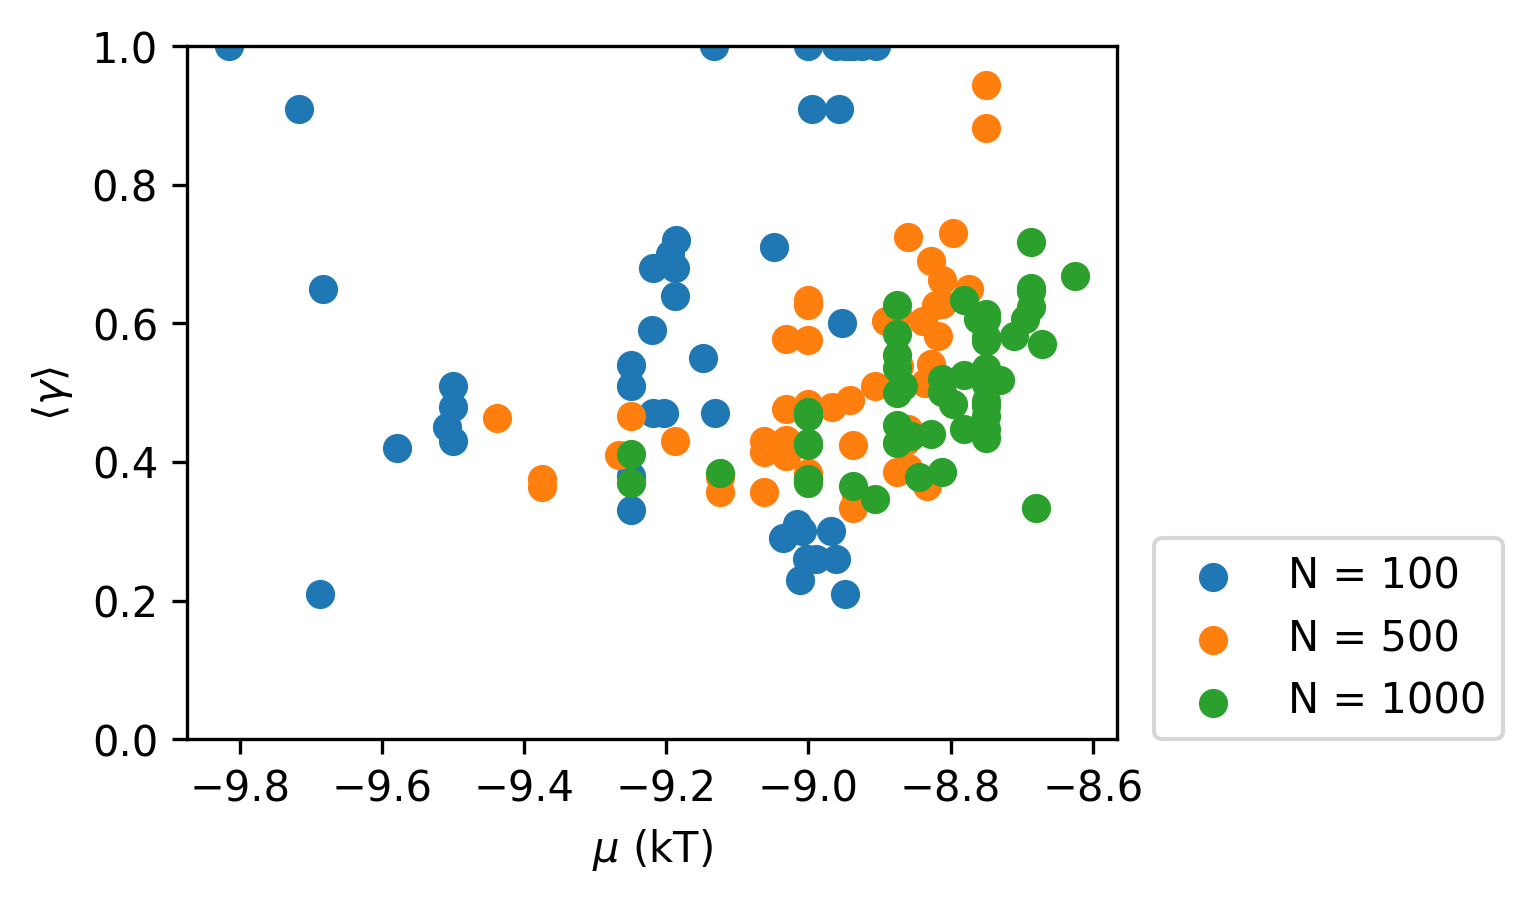

In [15]:
chain_lengths = [100, 500, 1000]

plt.figure(figsize=(4, 3), dpi=300)

for chain_length in chain_lengths:
    mu_plot = list(all_mu[chain_length].values())
    avg_gamma_plot = list(all_avg_gamma[chain_length].values())
    plt.scatter(mu_plot, avg_gamma_plot, label=f"N = {chain_length}")

plt.xlabel(r"$\mu$ (kT)")
plt.ylabel(r"$\langle\gamma\rangle$")
plt.ylim((0, 1))
plt.legend(loc=(1.04, 0))
plt.show()

#### Load Cluster Size Distributions

In [42]:
# Specify the file into which Rg was stored for 3D realizations of simulated chain lengths
# This file is created by get_Rg.py
Rg_file = "Rg_dist.csv"

# For what chain length is the cluster size distribution desired?
chain_length = 1000
sims = len_to_sim[chain_length]

# Load cluster size distributions
cluster_sizes = {}
for i, sim in enumerate(sims):

    # Check if cluster sizes were evaluated for the simulation
    Rg_path = os.path.join(sim_paths[sim], Rg_file)
    if not os.path.exists(Rg_path):
        print(f"Missing Rg: {sim}")
        continue
    
    # Load cluster size distribution
    cluster_sizes[sim] = np.loadtxt(Rg_path, skiprows=1)

cluster_sizes_arr = np.concatenate(list(cluster_sizes.values()))

#### Plot Cluster Size Distribution for a Single Chain Length

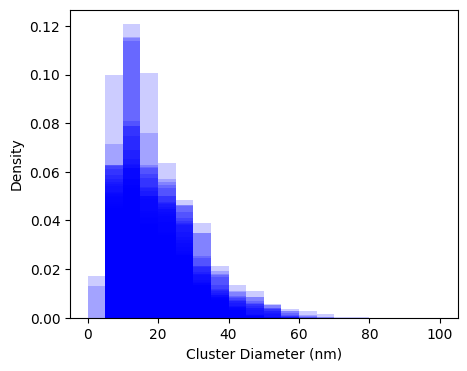

In [44]:
# Plot the cluster size distribution (seperately by simulation)
bins = np.linspace(0, 100, 21)
plt.figure(figsize=(5,4))
for sim in sims:
    plt.hist(cluster_sizes[sim]*2, bins=bins, density=True, color="blue", alpha=0.2)
plt.xlabel("Cluster Diameter (nm)")
plt.ylabel("Density")
plt.show()

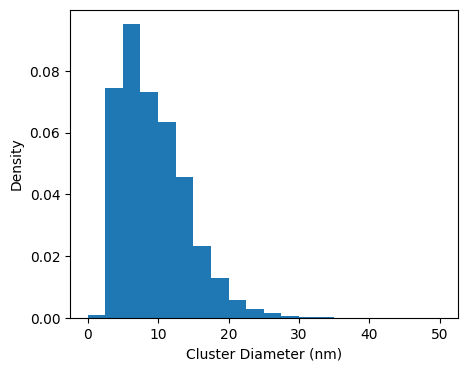

In [43]:
# Plot the cluster size distribution (pooling all simulations)
bins = np.linspace(0, 50, 21)
plt.figure(figsize=(5,4))
plt.hist(cluster_sizes_arr, bins=bins, density=True)
plt.xlabel("Cluster Diameter (nm)")
plt.ylabel("Density")
plt.show()

#### Plot Cluster Size Distribution for Variable Chain Lengths

In [48]:
def has_only_one_line(file_path):
    """So I can skip empty Rg files.
    """
    try:
        with open(file_path, 'r') as file:
            first_line = file.readline()
            return first_line and file.readline() == ''
    except IOError:
        return False

Empy Rg: sim_8
Empy Rg: sim_34
Empy Rg: sim_110
Empy Rg: sim_111
Empy Rg: sim_128
Empy Rg: sim_144
Empy Rg: sim_251
Missing Rg: sim_504


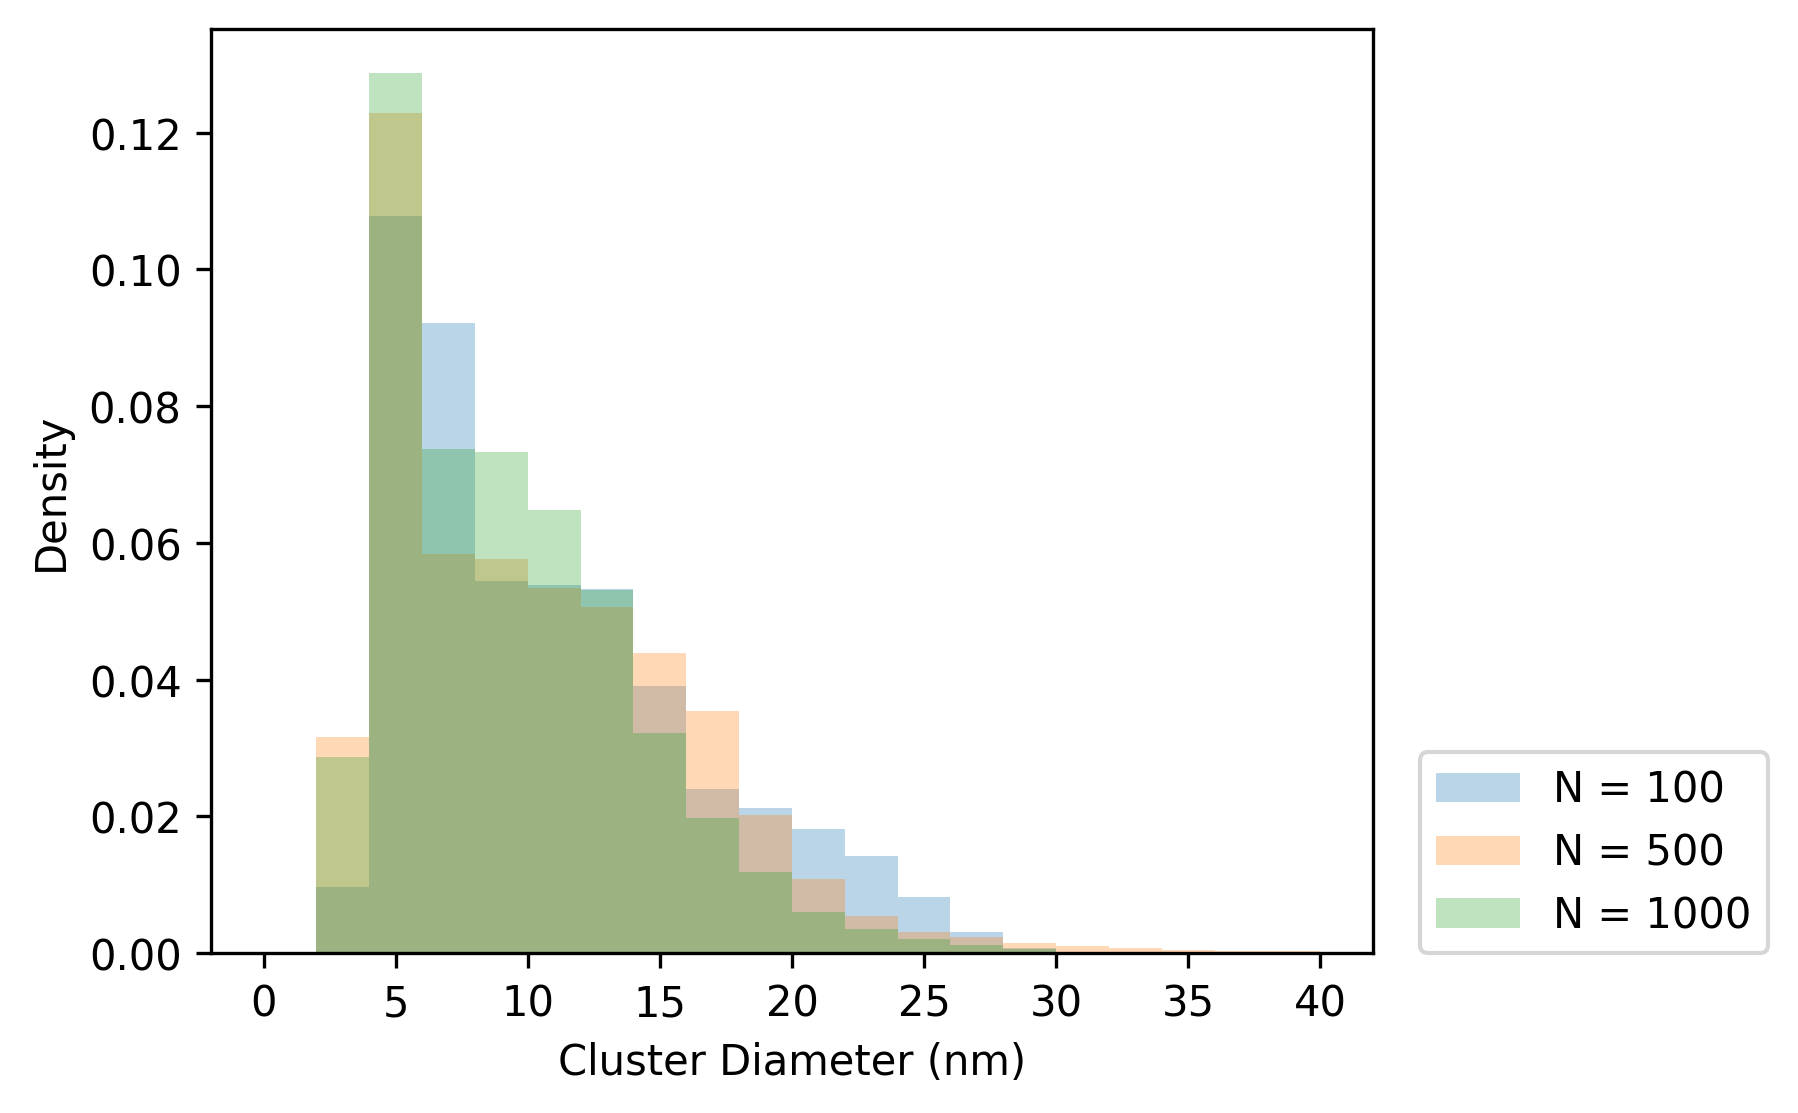

In [52]:
chain_lengths = [100, 500, 1000]
bins = np.linspace(0, 40, 21)

plt.figure(figsize=(5,4), dpi=300)

for chain_length in chain_lengths:
    sims = len_to_sim[chain_length]

    # Load cluster size distributions
    cluster_sizes = {}
    for i, sim in enumerate(sims):

        # Check if cluster sizes were evaluated for the simulation
        Rg_path = os.path.join(sim_paths[sim], Rg_file)
        if not os.path.exists(Rg_path):
            print(f"Missing Rg: {sim}")
            continue
        if has_only_one_line(Rg_path):
            print(f"Empy Rg: {sim}")
            continue

        # Load cluster size distribution
        cluster_sizes[sim] = np.loadtxt(Rg_path, skiprows=1)

    cluster_sizes_arr = np.concatenate(list(cluster_sizes.values()))
    plt.hist(cluster_sizes_arr, bins=bins, density=True, label=f"N = {chain_length}", alpha = 0.3)
    
plt.xlabel("Cluster Diameter (nm)")
plt.ylabel("Density")
plt.legend(loc=(1.04, 0))
plt.show()

#### Use the Same Bin Edges as [ChromEMT](https://www.science.org/doi/10.1126/science.aag0025#supplementary-materials)

Empy Rg: sim_8
Empy Rg: sim_34
Empy Rg: sim_110
Empy Rg: sim_111
Empy Rg: sim_128
Empy Rg: sim_144
Empy Rg: sim_251
Missing Rg: sim_504


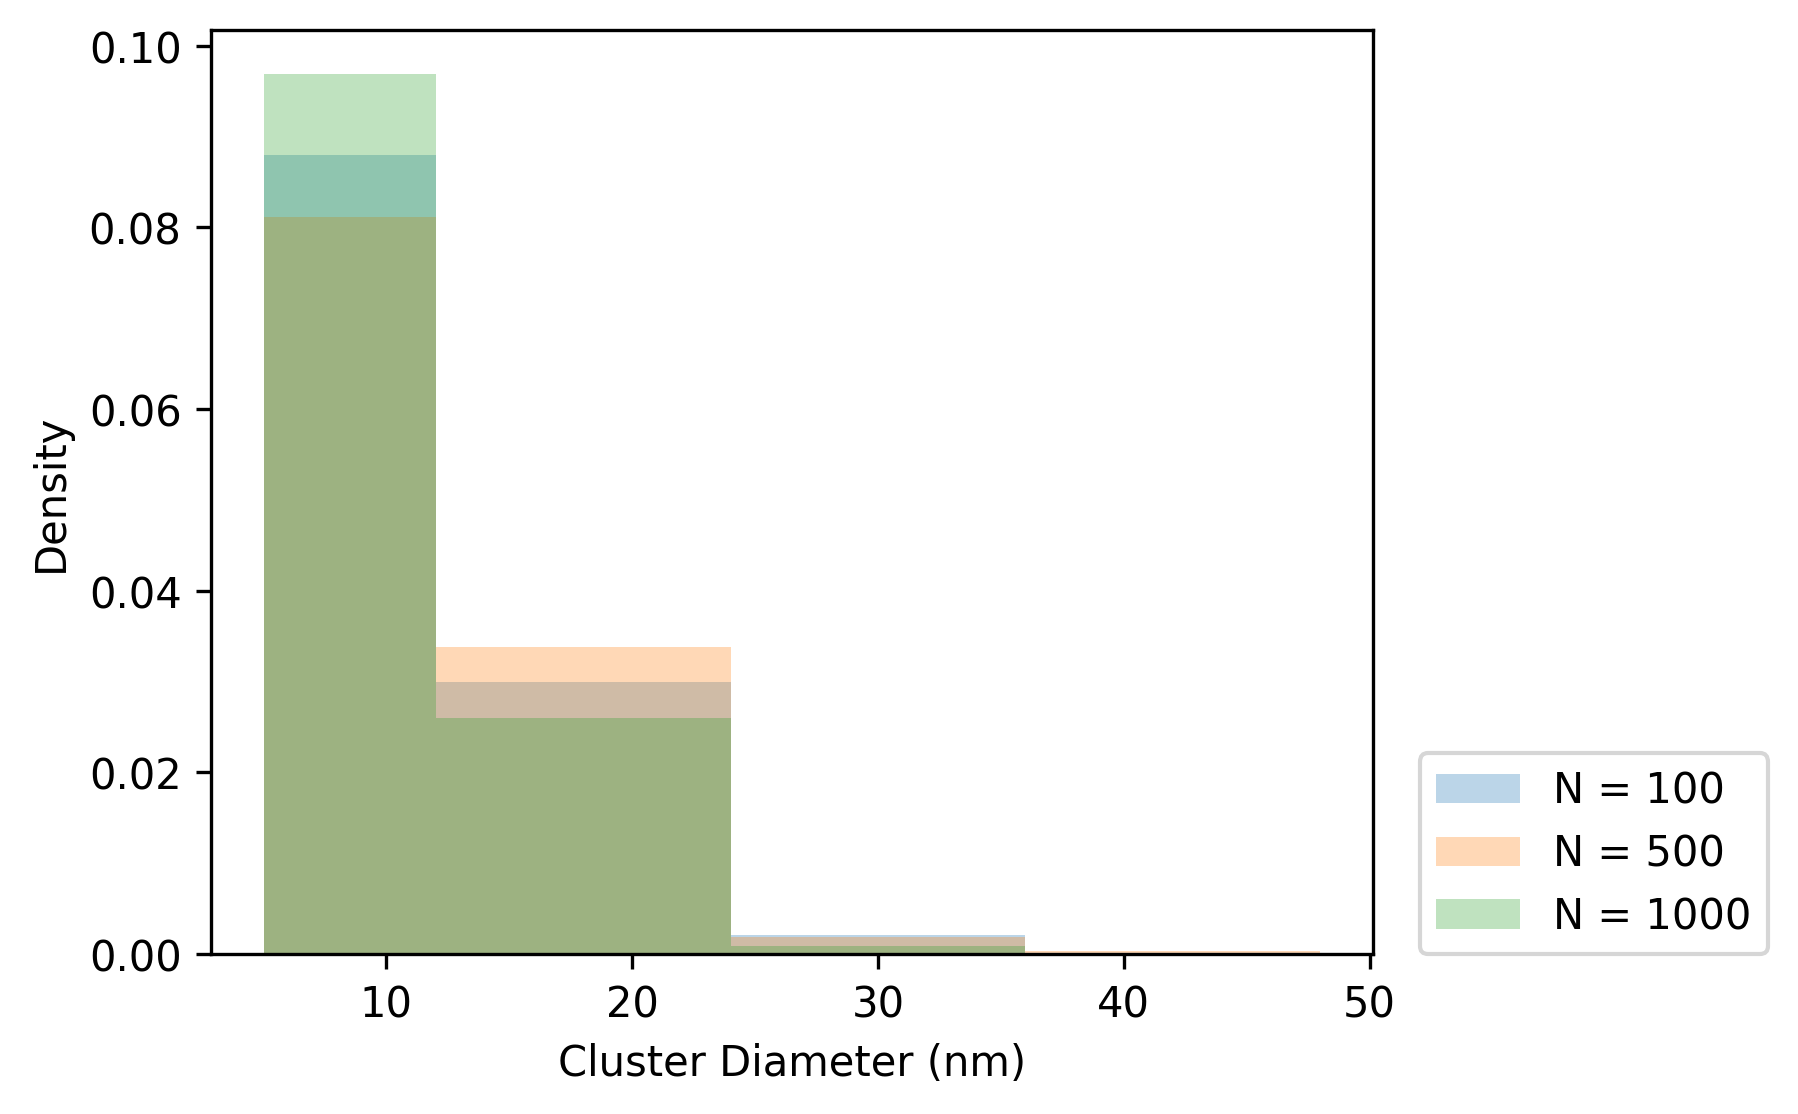

In [53]:
chain_lengths = [100, 500, 1000]
bins = [5, 12, 24, 36, 48]

plt.figure(figsize=(5,4), dpi=300)

for chain_length in chain_lengths:
    sims = len_to_sim[chain_length]

    # Load cluster size distributions
    cluster_sizes = {}
    for i, sim in enumerate(sims):

        # Check if cluster sizes were evaluated for the simulation
        Rg_path = os.path.join(sim_paths[sim], Rg_file)
        if not os.path.exists(Rg_path):
            print(f"Missing Rg: {sim}")
            continue
        if has_only_one_line(Rg_path):
            print(f"Empy Rg: {sim}")
            continue

        # Load cluster size distribution
        cluster_sizes[sim] = np.loadtxt(Rg_path, skiprows=1)

    cluster_sizes_arr = np.concatenate(list(cluster_sizes.values()))
    plt.hist(cluster_sizes_arr, bins=bins, density=True, label=f"N = {chain_length}", alpha = 0.3)
    
plt.xlabel("Cluster Diameter (nm)")
plt.ylabel("Density")
plt.legend(loc=(1.04, 0))
plt.show()